In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings 
warnings.filterwarnings('ignore')
import os 
import re
import FinanceDataReader as fdr
import time

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score ,accuracy_score, precision_score, recall_score, confusion_matrix
import joblib 
from sklearn.preprocessing import MinMaxScaler

rfc = RandomForestClassifier()
xgb = XGBClassifier()
cat = CatBoostClassifier()
models = [rfc,xgb,cat]

# 함수

In [3]:
df_kospi = pd.read_csv('./data/recent_kospi_list.csv',index_col=0)
def corp_code(corp_name):
    code = df_kospi[df_kospi['Name']==corp_name]['Symbol'].iloc[0]
    code = str(code).zfill(6)
    return code

# 주가데이터
def stock_price(code,bgn_date= '2016-01-01',end_date= '2022-03-31'):

    df_p = fdr.DataReader(code,bgn_date,end_date)
    df_p = df_p.reset_index()
    df_p = df_p.rename(columns = {'Date': '날짜'})
    df_p = df_p.set_index('날짜',drop=True)
    
    return df_p


def mscaler(df):

    df.index = pd.DatetimeIndex(df.index)
    col_list = df.columns
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[col_list] = scaler.fit_transform(df[col_list])
    df_scaled = df_scaled.rename(columns={'Close':'Close_scaled'})
    
    return df_scaled

In [4]:
def merge(df_count,df_p, df_p_scaled):
    df_merge = pd.merge(df_count,df_p_scaled['Close_scaled'],left_index=True,right_index=True, how='right')
    df_merge = pd.merge(df_merge,df_p['Close'],left_index=True,right_index=True, how='right')
    return df_merge

def add_target(df_merge,window_size, period_rate):

    earning_lst = []
    for i in range(len(df_merge)-window_size):
        
        earning_rate = (df_merge.iloc[i+window_size,-1]- df_merge.iloc[i,-1])/df_merge.iloc[i,-1]

        if earning_rate >= period_rate:
            earning_lst.append(1)
        else:
            earning_lst.append(0)

    df_model = df_merge.iloc[:-window_size,:]
    df_model['target'] = earning_lst
    
    return df_model

In [5]:
pd.set_option('display.max.colwidth', 70)

# 모델결과 보기

## 7일 10% (x)

In [27]:
result_7_10 = pd.read_csv('./data/model_result/machine_model_7일_0.1.csv',index_col=0)
result_7_10

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소
0,화신,XGBClassifier,0.956522,0.8,0.5,0.799065,./data/machine_model_7일_0.1/화신_XGBClassifier.pkl


## 7일 15% (없음)

In [28]:
result_7_15 = pd.read_csv('./data/model_result/machine_model_7일_0.15.csv',index_col=0)
result_7_15

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소


## 30일 5%

In [69]:
result_30_5 = pd.read_csv('./data/model_result/machine_model_30일_0.05.csv',index_col=0)
result_30_5

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소
0,LX하우시스,CatBoostClassifier,0.869565,0.909091,0.476190,0.875922,./data/machine_model_30일_0.05/LX하우시스_CatBoostClassifier.pkl
1,TCC스틸,RandomForestClassifier,0.673913,0.658537,0.627907,0.731134,./data/machine_model_30일_0.05/TCC스틸_RandomForestClassifier.pkl
2,TCC스틸,XGBClassifier,0.706522,0.750000,0.558140,0.724964,./data/machine_model_30일_0.05/TCC스틸_XGBClassifier.pkl
3,TCC스틸,CatBoostClassifier,0.684783,0.640000,0.744186,0.743000,./data/machine_model_30일_0.05/TCC스틸_CatBoostClassifier.pkl
4,경인전자,RandomForestClassifier,0.695652,0.852941,0.557692,0.794952,./data/machine_model_30일_0.05/경인전자_RandomForestClassifier.pkl
5,경인전자,XGBClassifier,0.630435,0.846154,0.423077,0.801202,./data/machine_model_30일_0.05/경인전자_XGBClassifier.pkl
6,금호건설,RandomForestClassifier,0.771739,0.612903,0.678571,0.818638,./data/machine_model_30일_0.05/금호건설_RandomForestClassifier.pkl
7,금호건설,CatBoostClassifier,0.826087,0.676471,0.821429,0.860491,./data/machine_model_30일_0.05/금호건설_CatBoostClassifier.pkl
8,대성홀딩스,RandomForestClassifier,0.663043,0.663043,1.000000,0.553675,./data/machine_model_30일_0.05/대성홀딩스_RandomForestClassifier.pkl
9,대성홀딩스,XGBClassifier,0.663043,0.663043,1.000000,0.567425,./data/machine_model_30일_0.05/대성홀딩스_XGBClassifier.pkl


## 30일 10%

In [109]:
result_30_10 = pd.read_csv('./data/model_result/machine_model_30일_0.1.csv',index_col=0)
result_30_10

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소
0,TCC스틸,RandomForestClassifier,0.728261,0.647059,0.628571,0.754637,./data/machine_model_30일_0.1/TCC스틸_RandomForestClassifier.pkl
1,TCC스틸,XGBClassifier,0.782609,0.777778,0.600000,0.744862,./data/machine_model_30일_0.1/TCC스틸_XGBClassifier.pkl
2,TCC스틸,CatBoostClassifier,0.836957,0.954545,0.600000,0.847368,./data/machine_model_30일_0.1/TCC스틸_CatBoostClassifier.pkl
3,대우조선해양,XGBClassifier,0.836957,0.687500,0.523810,0.748156,./data/machine_model_30일_0.1/대우조선해양_XGBClassifier.pkl
4,대우조선해양,CatBoostClassifier,0.815217,0.642857,0.428571,0.814554,./data/machine_model_30일_0.1/대우조선해양_CatBoostClassifier.pkl
5,대웅,CatBoostClassifier,0.880435,0.705882,0.666667,0.925676,./data/machine_model_30일_0.1/대웅_CatBoostClassifier.pkl
6,디아이씨,XGBClassifier,0.869565,0.725000,0.966667,0.940591,./data/machine_model_30일_0.1/디아이씨_XGBClassifier.pkl
7,디아이씨,CatBoostClassifier,0.880435,0.731707,1.000000,0.967473,./data/machine_model_30일_0.1/디아이씨_CatBoostClassifier.pkl
8,세진중공업,RandomForestClassifier,0.815217,0.733333,0.458333,0.793811,./data/machine_model_30일_0.1/세진중공업_RandomForestClassifier.pkl
9,세진중공업,XGBClassifier,0.815217,0.769231,0.416667,0.805760,./data/machine_model_30일_0.1/세진중공업_XGBClassifier.pkl


## 30일 15%

In [115]:
result_30_15 = pd.read_csv('./data/model_result/machine_model_30일_0.15.csv',index_col=0)
result_30_15

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소
0,대우조선해양,RandomForestClassifier,0.858696,0.642857,0.529412,0.823137,./data/machine_model_30일_0.15/대우조선해양_RandomForestClassifier.pkl
1,대우조선해양,XGBClassifier,0.880435,0.687500,0.647059,0.861961,./data/machine_model_30일_0.15/대우조선해양_XGBClassifier.pkl
2,대우조선해양,CatBoostClassifier,0.902174,0.900000,0.529412,0.841569,./data/machine_model_30일_0.15/대우조선해양_CatBoostClassifier.pkl
3,대웅,RandomForestClassifier,0.902174,0.687500,0.733333,0.937229,./data/machine_model_30일_0.15/대웅_RandomForestClassifier.pkl
4,대웅,XGBClassifier,0.923913,0.785714,0.733333,0.934199,./data/machine_model_30일_0.15/대웅_XGBClassifier.pkl
5,디아이씨,RandomForestClassifier,0.826087,0.644444,1.000000,0.951834,./data/machine_model_30일_0.15/디아이씨_RandomForestClassifier.pkl
6,디아이씨,XGBClassifier,0.913043,0.783784,1.000000,0.973727,./data/machine_model_30일_0.15/디아이씨_XGBClassifier.pkl
7,디아이씨,CatBoostClassifier,0.880435,0.725000,1.000000,0.998084,./data/machine_model_30일_0.15/디아이씨_CatBoostClassifier.pkl
8,삼성엔지니어링,XGBClassifier,0.880435,0.666667,0.428571,0.826923,./data/machine_model_30일_0.15/삼성엔지니어링_XGBClassifier.pkl
9,일진다이아,RandomForestClassifier,0.989130,0.750000,1.000000,0.996255,./data/machine_model_30일_0.15/일진다이아_RandomForestClassifier.pkl


## 90일 5%

In [32]:
result_90_5 = pd.read_csv('./data/model_result/machine_model_90일_0.05.csv',index_col=0)
result_90_5

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소
0,HMM,RandomForestClassifier,0.65625,0.645161,1.000000,0.381250,./data/machine_model_90일_0.05/HMM_RandomForest...
1,HMM,XGBClassifier,0.62500,0.625000,1.000000,0.841667,./data/machine_model_90일_0.05/HMM_XGBClassifie...
2,HMM,CatBoostClassifier,0.65625,0.645161,1.000000,0.691667,./data/machine_model_90일_0.05/HMM_CatBoostClas...
3,HSD엔진,RandomForestClassifier,0.84375,0.956522,0.846154,0.945513,./data/machine_model_90일_0.05/HSD엔진_RandomFore...
4,HSD엔진,XGBClassifier,0.81250,0.954545,0.807692,0.961538,./data/machine_model_90일_0.05/HSD엔진_XGBClassif...
...,...,...,...,...,...,...,...
64,한화에어로스페이스,XGBClassifier,0.68750,0.923077,0.571429,0.904762,./data/machine_model_90일_0.05/한화에어로스페이스_XGBCla...
65,현대미포조선,RandomForestClassifier,0.53125,0.846154,0.458333,0.575521,./data/machine_model_90일_0.05/현대미포조선_RandomFor...
66,황금에스티,RandomForestClassifier,0.65625,0.714286,0.588235,0.662745,./data/machine_model_90일_0.05/황금에스티_RandomFore...
67,황금에스티,XGBClassifier,0.65625,0.666667,0.705882,0.645098,./data/machine_model_90일_0.05/황금에스티_XGBClassif...


## 90일 10%

In [33]:
result_90_10 = pd.read_csv('./data/model_result/machine_model_90일_0.1.csv',index_col=0)
result_90_10

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소
0,HSD엔진,RandomForestClassifier,0.65625,0.750000,0.631579,0.783401,./data/machine_model_90일_0.1/HSD엔진_RandomFores...
1,HSD엔진,XGBClassifier,0.68750,0.846154,0.578947,0.850202,./data/machine_model_90일_0.1/HSD엔진_XGBClassifi...
2,HSD엔진,CatBoostClassifier,0.75000,0.923077,0.631579,0.910931,./data/machine_model_90일_0.1/HSD엔진_CatBoostCla...
3,KEC,RandomForestClassifier,0.78125,0.800000,0.615385,0.823887,./data/machine_model_90일_0.1/KEC_RandomForestC...
4,KEC,XGBClassifier,0.84375,0.900000,0.692308,0.927126,./data/machine_model_90일_0.1/KEC_XGBClassifier...
5,KEC,CatBoostClassifier,0.78125,0.800000,0.615385,0.866397,./data/machine_model_90일_0.1/KEC_CatBoostClass...
6,SK하이닉스,RandomForestClassifier,0.46875,0.750000,0.480000,0.454286,./data/machine_model_90일_0.1/SK하이닉스_RandomFore...
7,SK하이닉스,XGBClassifier,0.56250,0.739130,0.680000,0.342857,./data/machine_model_90일_0.1/SK하이닉스_XGBClassif...
8,SK하이닉스,CatBoostClassifier,0.56250,0.739130,0.680000,0.325714,./data/machine_model_90일_0.1/SK하이닉스_CatBoostCl...
9,TCC스틸,RandomForestClassifier,0.65625,0.857143,0.692308,0.711538,./data/machine_model_90일_0.1/TCC스틸_RandomFores...


## 90일 15%

In [34]:
result_90_15 = pd.read_csv('./data/model_result/machine_model_90일_0.15.csv',index_col=0)
result_90_15

,회사이름,모델이름,accuracy,precision,recall,roc_auc,모델주소
0,DB하이텍,RandomForestClassifier,0.65625,0.954545,0.677419,0.612903,./data/machine_model_90일_0.15/DB하이텍_RandomFore...
1,HSD엔진,XGBClassifier,0.81250,0.727273,0.727273,0.863636,./data/machine_model_90일_0.15/HSD엔진_XGBClassif...
2,HSD엔진,CatBoostClassifier,0.84375,0.750000,0.818182,0.857143,./data/machine_model_90일_0.15/HSD엔진_CatBoostCl...
3,KEC,XGBClassifier,0.96875,0.900000,1.000000,0.985507,./data/machine_model_90일_0.15/KEC_XGBClassifie...
4,KEC,CatBoostClassifier,0.84375,0.700000,0.777778,0.966184,./data/machine_model_90일_0.15/KEC_CatBoostClas...
5,SK하이닉스,XGBClassifier,0.56250,0.619048,0.684211,0.445344,./data/machine_model_90일_0.15/SK하이닉스_XGBClassi...
6,TCC스틸,RandomForestClassifier,0.65625,0.916667,0.523810,0.677489,./data/machine_model_90일_0.15/TCC스틸_RandomFore...
7,TCC스틸,XGBClassifier,0.65625,0.916667,0.523810,0.712121,./data/machine_model_90일_0.15/TCC스틸_XGBClassif...
8,TCC스틸,CatBoostClassifier,0.65625,0.750000,0.714286,0.632035,./data/machine_model_90일_0.15/TCC스틸_CatBoostCl...
9,경인전자,XGBClassifier,0.71875,0.666667,0.500000,0.691667,./data/machine_model_90일_0.15/경인전자_XGBClassifi...


# 모델 검증

## 함수

In [6]:
def model_test_data(corp_name, save_path, window_size, period_rate):
    code = corp_code(corp_name)
    df_p = stock_price(code)
    df_p_scaled = mscaler(df_p)
    
    path = './data/데이터_뉴스키워드빈도/'
    file_path = os.path.join(path,corp_name+'.csv')
    df_count = pd.read_csv(file_path,index_col=0)
    df_count.index = pd.DatetimeIndex(df_count.index)

    df_merge = merge(df_count,df_p,df_p_scaled)

    df_model = add_target(df_merge,window_size=window_size, period_rate= period_rate)

    x_train = df_model.loc[:'2021-10-01',:'Close_scaled']
    y_train = df_model.loc[:'2021-10-01','target']

    x_test = df_model.loc['2021-10-01':,:'Close_scaled']
    y_test = df_model.loc['2021-10-01':,'target']
    
    return x_train, y_train, x_test, y_test

In [7]:
def feature_visualization(save_path,num):
    
    model = joblib.load(save_path)
    # 배열형태로 반환
    ft_importance_values = model.feature_importances_

    # 정렬과 시각화를 쉽게 하기 위해 series 전환
    ft_series = pd.Series(ft_importance_values, index = x_test.columns)
    ft_top20 = ft_series.sort_values(ascending=False)[:num]

    # 시각화
    plt.figure(figsize=(8,6))
    plt.title('Feature Importance Top 20')
    sns.barplot(x=ft_top20, y=ft_top20.index)
    plt.show()
    
    return ft_top20

In [101]:
df_count = pd.read_csv('./data/데이터_뉴스키워드빈도/AK홀딩스.csv',index_col=0)
df_count.head()

,급등,영업익,근처,원대,매물대,존재,외국인,애경유화,속보,전년비,...,애경그룹,이석주,증시,실적,대표,지분,제주항공,동향,뉴스,상승
날짜,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 30일 5%

In [102]:
corp_name = 'LX하우시스'
save_path = './data/machine_model_30일_0.05/LX하우시스_CatBoostClassifier.pkl'
window_size = 30
period_rate = 0.05

model = joblib.load(save_path)
x_train,y_train,x_test,y_test = model_test_data(corp_name,save_path,window_size=window_size, period_rate=period_rate)
pred = model.predict(x_test)
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        92
           1       0.00      0.00      0.00         0

    accuracy                           0.64        92
   macro avg       0.50      0.32      0.39        92
weighted avg       1.00      0.64      0.78        92



In [103]:
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
print(accuracy)
print(precision)

0.6413043478260869
0.0


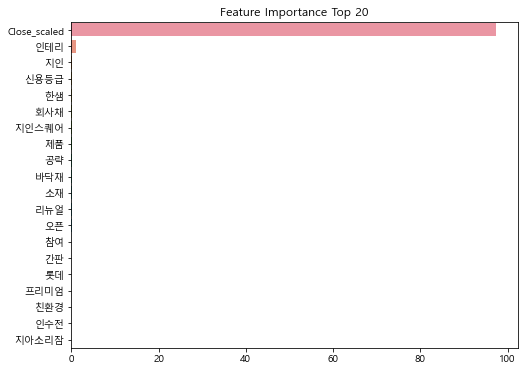

Close_scaled    97.470348
인테리              1.012421
지인               0.228722
신용등급             0.171792
한샘               0.142986
회사채              0.119343
지인스퀘어            0.118225
제품               0.111379
공략               0.067565
바닥재              0.055336
소재               0.051802
리뉴얼              0.043830
오픈               0.042295
참여               0.036087
간판               0.034707
롯데               0.031623
프리미엄             0.031496
친환경              0.030176
인수전              0.026028
지아소리잠            0.024573
dtype: float64

In [106]:
feature_visualization(save_path,20)

              precision    recall  f1-score   support

           0       0.93      0.61      0.74        64
           1       0.50      0.89      0.64        28

    accuracy                           0.70        92
   macro avg       0.71      0.75      0.69        92
weighted avg       0.80      0.70      0.71        92

0.6956521739130435
0.5
0.8928571428571429


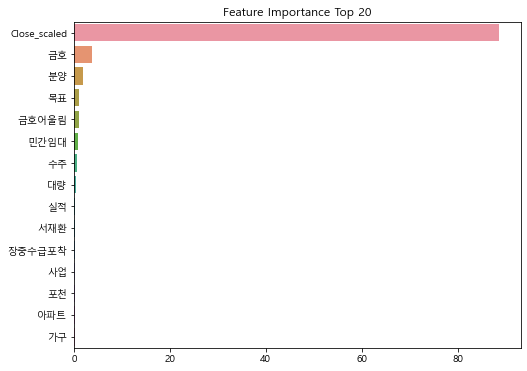

Close_scaled    88.722223
금호               3.632596
분양               1.784149
목표               0.984740
금호어울림            0.911158
민간임대             0.885292
수주               0.504918
대량               0.389142
실적               0.223355
서재환              0.220072
장중수급포착           0.195233
사업               0.192044
포천               0.182805
아파트              0.182271
가구               0.146595
dtype: float64

In [13]:
corp_name = '금호건설'
save_path = './data/machine_model_30일_0.05/금호건설_CatBoostClassifier.pkl'
window_size = 30
period_rate = 0.05

model = joblib.load(save_path)
x_train,y_train,x_test,y_test = model_test_data(corp_name,save_path,window_size=window_size, period_rate=period_rate)
pred = model.predict(x_test)
print(classification_report(y_test,pred))
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test, pred)
print(accuracy)
print(precision)
print(recall)
feature_visualization(save_path,15)

## 30일 10%

### TCC스틸

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        57
           1       0.70      0.54      0.61        35

    accuracy                           0.74        92
   macro avg       0.73      0.70      0.71        92
weighted avg       0.73      0.74      0.73        92

0.7391304347826086
0.7037037037037037
0.5428571428571428


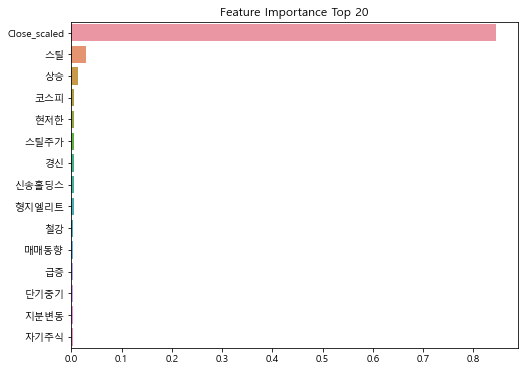

Close_scaled    0.845959
스틸              0.029951
상승              0.013790
코스피             0.006284
현저한             0.006107
스틸주가            0.006017
경신              0.005213
신송홀딩스           0.004812
형지엘리트           0.004419
철강              0.004235
매매동향            0.003770
급증              0.003763
단기중기            0.003647
지분변동            0.003569
자기주식            0.003298
dtype: float64

In [14]:
corp_name = 'TCC스틸'
save_path = './data/machine_model_30일_0.1/TCC스틸_RandomForestClassifier.pkl'
window_size = 30
period_rate = 0.1

model = joblib.load(save_path)
x_train,y_train,x_test,y_test = model_test_data(corp_name,save_path,window_size=window_size, period_rate=period_rate)
pred = model.predict(x_test)
print(classification_report(y_test,pred))
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test, pred)
print(accuracy)
print(precision)
print(recall)
feature_visualization(save_path,15)

# 0.728261 0.647059 0.628571

## 30일 15%

### 대우조선해양

              precision    recall  f1-score   support

           0       0.89      0.95      0.92        75
           1       0.67      0.47      0.55        17

    accuracy                           0.86        92
   macro avg       0.78      0.71      0.73        92
weighted avg       0.85      0.86      0.85        92

0.8586956521739131
0.6666666666666666
0.47058823529411764


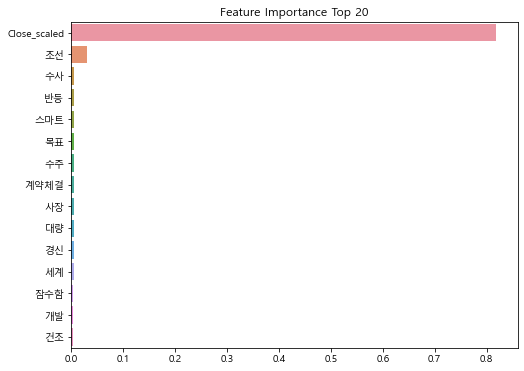

Close_scaled    0.818887
조선              0.029605
수사              0.005794
반등              0.005161
스마트             0.004897
목표              0.004854
수주              0.004775
계약체결            0.004711
사장              0.004526
대량              0.004505
경신              0.004498
세계              0.004438
잠수함             0.004103
개발              0.004069
건조              0.004059
dtype: float64

In [15]:
corp_name = '대우조선해양'
save_path = './data/machine_model_30일_0.15/대우조선해양_RandomForestClassifier.pkl'
window_size = 30
period_rate = 0.15

model = joblib.load(save_path)
x_train,y_train,x_test,y_test = model_test_data(corp_name,save_path,window_size=window_size, period_rate=period_rate)
pred = model.predict(x_test)
print(classification_report(y_test,pred))
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test, pred)
print(accuracy)
print(precision)
print(recall)
feature_visualization(save_path,15)


In [17]:
y_test[y_test==1]

날짜
2022-01-18    1
2022-01-19    1
2022-01-20    1
2022-01-21    1
2022-01-24    1
2022-01-25    1
2022-01-26    1
2022-01-27    1
2022-01-28    1
2022-02-04    1
2022-02-07    1
2022-02-08    1
2022-02-09    1
2022-02-10    1
2022-02-11    1
2022-02-14    1
2022-02-15    1
Name: target, dtype: int64

In [40]:
print(np.where(x_test.loc['2022-01-18',:] !=0))
print(np.where(x_test.loc['2022-01-19',:] !=0))
print(np.where(x_test.loc['2022-01-20',:] !=0))
print(np.where(x_test.loc['2022-01-21',:] !=0))
print(np.where(x_test.loc['2022-01-24',:] !=0))
print(np.where(x_test.loc['2022-01-26',:] !=0))
print(np.where(x_test.loc['2022-02-08',:] !=0))
print(np.where(x_test.loc['2022-02-14',:] !=0))

(array([38, 43, 87, 97], dtype=int64),)
(array([32, 55, 87, 97], dtype=int64),)
(array([97], dtype=int64),)
(array([97], dtype=int64),)
(array([97], dtype=int64),)
(array([97], dtype=int64),)
(array([97], dtype=int64),)
(array([97], dtype=int64),)


In [41]:
print(x_test.columns[[38, 43, 87, 97]])
print(x_test.columns[[32, 55, 87, 97]])

Index(['실적', '기업결합', '조선', 'Close_scaled'], dtype='object')
Index(['합병', '노조', '조선', 'Close_scaled'], dtype='object')
